# About
This notebook was used to investigate properties of the corpus of *E. coli* SRA runs.  
It was used to produce Table S1.

# Prereqs

In [59]:
import collections
import csv
import gzip
import pathlib
import time
import xml.etree.ElementTree

In [91]:
from matplotlib import pyplot

In [92]:
from html_table import Table, Row, Cell

In [58]:
%matplotlib inline

In [2]:
MAIN_DIR = pathlib.Path('/nfs/brubeck.bx.psu.edu/scratch5/nick/overlaps/auto/ecoli')
CSV_PATH = MAIN_DIR/'sra.runinfo3.csv.gz'
XML_PATH = MAIN_DIR/'sra.docsum2.xml.gz'

## Reading metadata

In [3]:
def read_runinfo(csv_path):
  start = time.perf_counter()
  int_fields = {'spots', 'spots_with_mates', 'avgLength', 'size_MB', 'InsertSize', 'InsertDev', 'ProjectID', 'TaxID'}
  runs = {}
  header = {}
  empty_lines = 0
  header_lines = 0
  try:
    with gzip.open(csv_path, 'rt') as csv_file:
      for row in csv.reader(csv_file):
        if not header:
          header_lines += 1
          for i, value in enumerate(row):
            header[i] = value
          RunInfo = collections.namedtuple('RunInfo', header.values())
          continue
        if len(row) == 0:
          empty_lines += 1
          continue
        assert len(row) == len(header), (len(row), row)
        header_matches = 0
        value_dict = {}
        for i, raw_value in enumerate(row):
          if raw_value == header[i]:
            header_matches += 1
          else:
            if header[i] in int_fields:
              try:
                value = int(raw_value)
              except ValueError:
                if header[i] == 'InsertDev':
                  value = float(raw_value)
                else:
                  print(f'{header[i]}: {raw_value!r}', file=sys.stderr)
            else:
              value = raw_value
          value_dict[header[i]] = value
        if header_matches > 5:
          header_lines += 1
          continue
        runs[value_dict['Run']] = RunInfo(**value_dict)
  except EOFError:
    print('Incomplete gzip.', file=sys.stderr)
  elapsed = time.perf_counter() - start
  print(f'{len(runs)} runs in {elapsed:0.1f} seconds (headers: {header_lines}, empty lines: {empty_lines})')
  return runs

In [4]:
def read_xml(xml_path):
  start = time.perf_counter()
  summaries = {}
  with gzip.open(xml_path) as xml_file:
    # Note: This takes about 1-2GB of memory.
    tree = xml.etree.ElementTree.parse(xml_file)
  docsum = tree.getroot()
  for exp in docsum:
    for run in exp.find('./Runs'):
      acc = run.attrib['acc']
      summaries[acc] = exp
  elapsed = time.perf_counter() - start
  print(f'{len(summaries)} experiments in {round(elapsed)} seconds')
  return summaries

In [29]:
def get_overlap(run, null=None, neg=True):
  readlen = run.avgLength//2
  if run.InsertSize == 0 or readlen == 0:
    return null
  overlap = min(readlen, run.InsertSize, readlen*2 - run.InsertSize)
  if neg:
    return overlap
  else:
    return max(0, overlap)

In [5]:
def rm_prefix(string, prefix):
  if string.startswith(prefix):
    return string[len(prefix):]
  else:
    return string

In [6]:
def truncate(string, max_len):
  if len(string) > max_len:
    return string[:max_len-1]+'…'
  else:
    return string

## Read in the metadata

In [7]:
RUNS = read_runinfo(CSV_PATH)

186022 runs in 11.5 seconds (headers: 1, empty lines: 0)


In [8]:
SUMMARIES = read_xml(XML_PATH)

186022 experiments in 43 seconds


## Reading group metadata

In [26]:
ABBREVIATIONS = {
  'European':'Euro.', 'Nucleotide':'Nuc.', 'Institute':'Inst.', 'Technology':'Tech.', 'The Pennsylvania':'Penn',
  'University':'Univ.', 'National':'Nat.', 'Department':'Dept.', 'Technological':'Tech.', 'Laboratory':'Lab.',
  'Biotechnology':'Biotech.',
}
class Study(collections.namedtuple('Study', ('title', 'study', 'center', 'lab', 'contact'))):
  __slots__ = ()
  @property
  def submitter(self):
    return (self.center, self.lab, self.contact)
  @classmethod
  def from_accession(cls, accession, summaries=SUMMARIES):
    try:
      experiment = summaries[accession]
    except KeyError:
      sys.stderr.write(f'Warning: Could not find XML summary for {accession}\n')
      raise
    return cls.from_experiment(experiment)
  @classmethod
  def from_experiment(cls, experiment):
    data = {'title':None, 'study':None, 'center':None, 'lab':None, 'contact':None}
    if not experiment:
      return cls(**data)
    data['title'] = experiment.find('./ExpXml/Summary/Title').text
    study_elem = experiment.find('./ExpXml/Study')
    data['study'] = study_elem.attrib.get('name')
    subm_elem = experiment.find('./ExpXml/Submitter')
    for field in 'center', 'lab', 'contact':
      data[field] = subm_elem.attrib.get(field+'_name')
    return cls(**data)
  def format_fields(self, max_len=None, null='?'):
    """Return a copy with the fields formatted for human reading."""
    strs = {}
    for field in self._fields:
      value = raw_value = getattr(self, field)
      if raw_value is None:
        value = null
      strs[field] = value
    # This is a common prefix that's lengthy and not too informative.
    strs['title'] = rm_prefix(strs['title'], 'Illumina MiSeq paired end sequencing; ')
    for field in 'center', 'lab', 'contact':
      value = raw_value = strs[field]
      # If it's all uppercase, make it titlecased to be easier to read.
      if len(raw_value) > 16 and raw_value == raw_value.upper():
        value = raw_value.title()
      for long, short in ABBREVIATIONS.items():
        value = value.replace(long, short)
      strs[field] = value
    if max_len is not None:
      for field, value in strs.items():
        strs[field] = truncate(value, max_len)
    return type(self)(**strs)

## Reading todo/launched/done lists

In [9]:
def read_file_as_list(list_path):
  line_list = []
  with list_path.open() as list_file:
    for line_raw in list_file:
      line_list.append(line_raw.strip())
  return line_list

In [10]:
def subtract_lists(list1: list, *lists) -> list:
  """Return a copy of `list1` but remove any items present in the other lists."""
  new_list = []
  remove_these: Set[list] = set()
  for list2 in lists:
    remove_these |= set(list2)
  for item in list1:
    if item not in remove_these:
      new_list.append(item)
  return new_list

# Platforms

## How many runs from each platform?

In [90]:
platform_counts = collections.defaultdict(collections.Counter)
for run in RUNS.values():
  platform_counts[run.Platform][run.Model] += 1
rows = []
all_total = 0
for platform, model_counts in platform_counts.items():
  total = 0
  for model, count in model_counts.items():
    total += count
    rows.append((platform, model, count))
  rows.append((platform, 'TOTAL', total))
  all_total += total
rows.append(('TOTAL', 'TOTAL', all_total))
Table(rows, header=('Platform', 'Model', 'Runs')).render()

Platform,Model,Runs
ILLUMINA,Illumina NovaSeq 6000,1375
ILLUMINA,Illumina HiSeq 2500,36034
ILLUMINA,Illumina MiSeq,75118
ILLUMINA,Illumina HiSeq 2000,18483
ILLUMINA,Illumina HiSeq 4000,7339
ILLUMINA,NextSeq 500,16471
ILLUMINA,HiSeq X Ten,16921
ILLUMINA,Illumina MiniSeq,237
ILLUMINA,NextSeq 550,1107
ILLUMINA,Illumina HiSeq 3000,362


# Groups

## How many runs does each group typically submit?

In [23]:
def divide_accessions_by_group(accessions, runs=RUNS, summaries=SUMMARIES):
  """Divide the list of accessions into sublists by submitting group."""
  acc_by_group = collections.defaultdict(list)
  for accession in accessions:
    study = Study.from_accession(accession)
    acc_by_group[study.submitter].append(accession)
  return acc_by_group

In [27]:
acc_by_group = divide_accessions_by_group(everything)

### What's the median?

In [42]:
all_counts = sorted(len(group_list) for group_list in acc_by_group.values())
all_counts[len(all_counts)//2]

10

### What's the distribution?

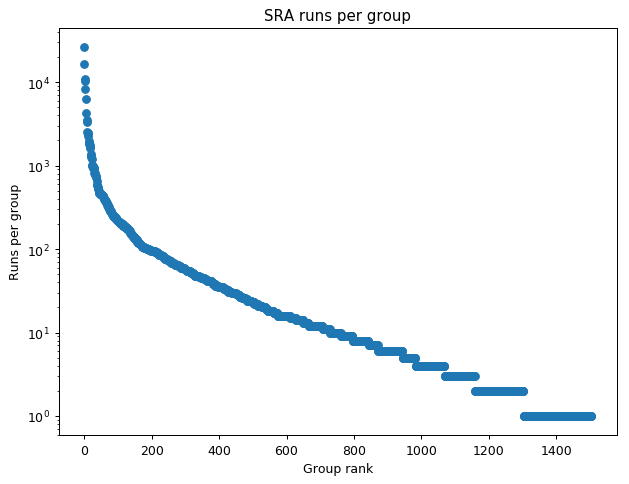

In [73]:
figure = pyplot.figure(dpi=90, figsize=(8,6))
axes = figure.add_subplot(1,1,1)
axes.set_yscale('log')
axes.set_title('SRA runs per group')
axes.set_ylabel('Runs per group')
axes.set_xlabel('Group rank')
axes.scatter(list(range(len(all_counts))), list(reversed(all_counts)))

Okay so there's clearly a long tail. A few groups have thousands of runs in the database.

### Who are the top 10 submitters?

In [56]:
rows = []
for group, group_list in sorted(acc_by_group.items(), key=lambda item: len(item[1]), reverse=True):
  if len(rows) >= 10:
    break
  count = len(group_list)
  acc = group_list[0]
  run = RUNS[acc]
  models = [rm_prefix(RUNS[acc].Model, 'Illumina ') for acc in group_list]
  model_counts = collections.Counter(models)
  model, model_count = model_counts.most_common(1)[0]
  model_pct = f'{100*model_count/count:0.0f}%'
  study = Study.from_accession(acc, summaries=SUMMARIES).format_fields(max_len=60)
  row = (count, model, model_pct, study.center, study.lab, study.contact)
  rows.append(row)
header = [
  ('', {'value':'Most common model', 'width':2}),
  ('Runs', 'Model', '%', 'Center', 'Lab', 'Contact')
]
Table(rows, header=header).render()

# Investigate new data
The most recent (August 2020) SRA export (`sra.runinfo3.csv.gz`, `sra.docsum2.xml.gz`) vs. the one from October 2019

In [13]:
# All runs from the new SRA export
everything = list(RUNS.keys())

In [14]:
master   = read_file_as_list(MAIN_DIR/'meta/todo.master.txt')
launched = read_file_as_list(MAIN_DIR/'meta/launched.txt')
done     = read_file_as_list(MAIN_DIR/'meta/done.txt')

In [15]:
old_todo = subtract_lists(master, launched, done)
new_todo = subtract_lists(everything, launched, done)

In [16]:
print(f"""everything:{len(everything):7d}
master:    {len(master):7d}
launched:  {len(launched):7d}
done:      {len(done):7d}
old todo:  {len(old_todo):7d}
new todo:  {len(new_todo):7d}""")

everything: 186022
master:     123663
launched:     1438
done:          360
old todo:   121912
new todo:   184264


### How many new runs are there?

In [17]:
len(set(everything) - set(master))

62409

### How many runs have been removed?
- These appear to have been deleted from the SRA

In [18]:
len(set(master) - set(everything))

50

### What's the mix of models in the new list?

In [21]:
models = collections.defaultdict(int)
for acc in new_todo:
  run = RUNS[acc]
  if run.Platform != 'ILLUMINA':
    continue
  model = rm_prefix(run.Model, 'Illumina ')
  models[model] += 1

In [22]:
rows = []
for model in sorted(models.keys()):
  rows.append((model, models[model]))
Table(rows).render()

Genome Analyzer,209
Genome Analyzer II,830
Genome Analyzer IIx,1568
HiScanSQ,35
HiSeq 1000,286
HiSeq 1500,431
HiSeq 2000,18468
HiSeq 2500,35743
HiSeq 3000,356
HiSeq 4000,7320
HiSeq X Five,558
